### Planned Unit Development (PUDs) with affordable housing in the Washington D.C. Area
This notebook shows utilization of Google Colab. Best used of uploaded to google colab. 

---

Data is from opendata.dc.gov
- [PUD](https://opendata.dc.gov/datasets/planned-unit-development-puds/explore?location=38.878434%2C-77.001490%2C12.30)
    - Download the .shp file from the menue
- [Affordable housing](https://opendata.dc.gov/datasets/affordable-housing/explore)
    - Download the .csv file
- Will also need the zoning_crosswalk.csv file located [here](https://drive.google.com/file/d/1RxxikCuiAelk71giceUrJWNAK34KBwDF/view)
 
---

This utilizes the geopands library. This library is a geolocation tuned pandas library for GIS applications.
It also uses rtree for joining. Most likeley, these packages are not pre-installed in google colab and will need to be done. 

In [2]:
!pip install geopandas
!apt-get install -y libspatialindex-dev
!pip install rtree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c6 libspatialindex6
The following NEW packages will be installed:
  libspatialindex-c6 libspatialindex-dev libspatialindex6
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 319 kB of archives.
After this operation, 1,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex6 amd64 1.9.3-2 [247 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-c6 amd64 1.9.3-2 [55.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-dev amd64 1.9.3-2 [16.0 kB]
Fetched 319 kB in 0s (2,871 kB/s)
Selecting previously unselected package libspatialindex6:amd64.
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../libspatialindex6_1.9.3-2_amd64.deb ...
U

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely import wkt
import rtree

In [4]:
# Connect Google Colab to Google Drive
from google.colab import drive
drive.mount('/content/gdrive') # connects Colab to your specific Google Drive
root_path = 'gdrive/My Drive/gis' # set root path to 'gis' folder with important files

Mounted at /content/gdrive


In [7]:
# Read in data as geodataframe and initialize coordinate reference system (CRS)
puds = gpd.read_file(root_path+'/input/Planned_Unit_Development_(PUDs).shp', crs = {'init' :'epsg:4326'})
aff = pd.read_csv(root_path+'/input/Affordable_Housing.csv')
crosswalk = pd.read_csv(root_path+'/input/zoning_crosswalk.csv')

In [14]:
#Take a look at the dataframes
puds['geometry'].head(5)

0    POLYGON ((-76.99751 38.90767, -76.99767 38.907...
1    POLYGON ((-77.04962 38.90387, -77.04994 38.903...
2    POLYGON ((-77.00118 38.90765, -77.00100 38.907...
3    POLYGON ((-76.99407 38.83091, -76.99390 38.830...
4    POLYGON ((-77.00097 38.90935, -77.00100 38.909...
Name: geometry, dtype: geometry

In [20]:
# Creat a geometry column in the affordable housing dataframe
aff['geometry'] = aff.apply(lambda row: Point(row.X, row.Y), axis=1)
aff = gpd.GeoDataFrame(aff, crs={'init' :'epsg:4326'}) #Depricated, use the below
#aff = gpd.GeoDataFrame(aff, crs={'epsg:4326'})

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [21]:
aff.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 865 entries, 0 to 864
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   X                              865 non-null    float64 
 1   Y                              865 non-null    float64 
 2   OBJECTID                       865 non-null    int64   
 3   MAR_WARD                       865 non-null    object  
 4   ADDRESS                        865 non-null    object  
 5   PROJECT_NAME                   865 non-null    object  
 6   STATUS_PUBLIC                  865 non-null    object  
 7   AGENCY_CALCULATED              862 non-null    object  
 8   TOTAL_AFFORDABLE_UNITS         865 non-null    int64   
 9   LATITUDE                       865 non-null    float64 
 10  LONGITUDE                      865 non-null    float64 
 11  AFFORDABLE_UNITS_AT_0_30_AMI   865 non-null    int64   
 12  AFFORDABLE_UNITS_AT_31_50_AM

In [23]:
# Use geospatial .sjoin() to identify which PUDs include affordable housing projects
puds_aff = gpd.sjoin(puds, aff, op='intersects', how='left')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-23-e010d5be1a63>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  puds_aff = gpd.sjoin(puds, aff, op='intersects', how='left')


In [24]:
# Merge crosswalk and puds_aff dataframe to create plain english categories.
puds_info = puds_aff.merge(crosswalk[['Zone_Cat']], how='left', left_on='PUD_ZONING', right_on=crosswalk['Zone'])

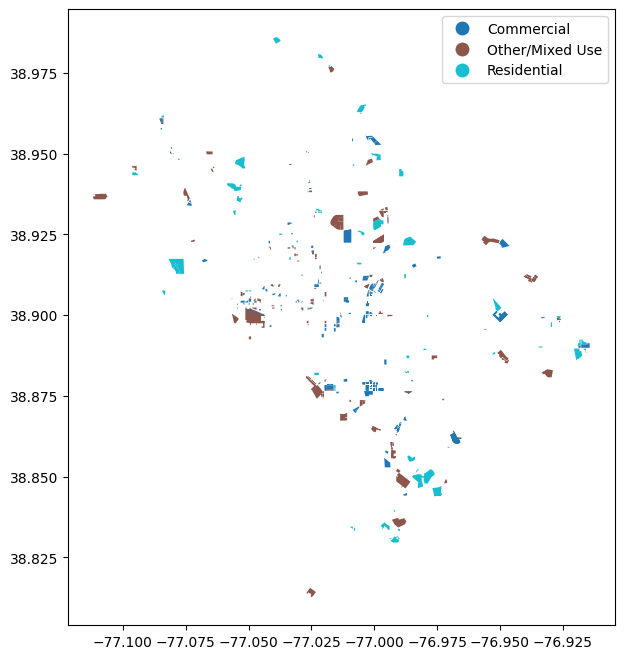

In [25]:
#PUDS by Zoning Category map
puds_info.plot(column='Zone_Cat', legend=True, figsize=(16,8));

In [34]:
puds.head(5)

,OBJECTID,PUD_NAME,PUD_WEB_UR,PUD_CHANGE,PUD_ZONING,PUD_STATUS,PUD_CASE_N,WARD,GIS_ID,PUD_FAR,UNITS_TOTA,UNITS_AFFO,PUD_HEIGHT,PARKING,DESCRIPTIO,SHAPEAREA,SHAPELEN,geometry
0,486563,Gallaudet University and JBG/6th Street Associ...,https://app.dcoz.dc.gov/Home/ViewCase?case_id=...,2nd-Stage PUD; Consolidated PUD & Related Map ...,"C-3-A, C-3-C",Final,15-24B,Ward 5,None,6.96,597,63,120,306,"Multi-parcel, multi-building project including...",0,0,"POLYGON ((-76.99751 38.90767, -76.99767 38.907..."
1,486564,Millennium Partners,https://app.dcoz.dc.gov/Home/ViewCase?case_id=...,"Official Digital Zoning Map of July 1, 2010",CR,Final,98-1,Ward 2,None,6.81,160-230,N/A,110,700-770 spaces,"Mixed-use development with retail, hotel, heal...",0,0,"POLYGON ((-77.04962 38.90387, -77.04994 38.903..."
2,486565,Gateway Market Center Inc.,https://app.dcoz.dc.gov/Home/ViewCase?case_id=...,PUD Modification 1/27/14,C-3-C,Final,06-40C,Ward 5,None,5.0,170-216,20% of units,80,215 spaces,Mixed-use retail residential building,0,0,"POLYGON ((-77.00118 38.90765, -77.00100 38.907..."
3,486566,Hazle II LLC,https://app.dcoz.dc.gov/Home/ViewCase?case_id=...,Case # 10-29,R-5-B,Withdrawn,10-29,Ward 8,None,2.67,35,35,50,14 spaces,DCHA apartment building,0,0,"POLYGON ((-76.99407 38.83091, -76.99390 38.830..."
4,486567,1 Neal Place LLC,https://app.dcoz.dc.gov/Home/ViewCase?case_id=...,Modification of Consequence to Second-Stage Pl...,C-3-C,Final,15-27F,Ward 5,None,7.1,1103,124,130,682 spaces,"Multi-building residential, retail, office, an...",0,0,"POLYGON ((-77.00097 38.90935, -77.00100 38.909..."


/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<Axes: >

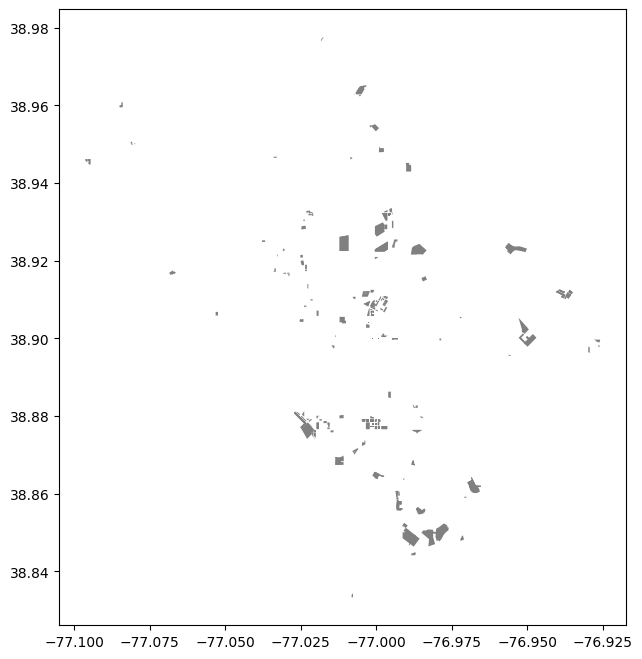

In [44]:
# PUDs that provide affordable housing
puds_info[puds_info['TOTAL_AFFORDABLE_UNITS']>0].plot(column='TOTAL_AFFORDABLE_UNITS',
                                                      color='grey',
                                                      figsize=(16,8))